# Imaging Lab 3: Improved Pixel Scanning

### EECS 16A: Designing Information Devices and Systems I, Fall 2015

**Name 1**:

**Login**: ee16a-


**Name 2**:

**Login**: ee16a-


## Table of Contents

* [Task1: Setup](#task1a)
    * [Light Sensor](#task1a)
    * [MSP430 Code](#task1b)
    * [Projector](#task1c)
* [Task 2: Multipixel Scanning](#task2a)
    * [Multipixel Scanning](#task2a)
    * [Scanning Matrix](#task2b)
    * [Real Image Scanning](#task2c)
    
* [Task 3: Imaging Simulator](#task3)
        
* [Task 4: Imaging Contest (Optional)](#task2d)
    * [Contest (Optional)](#contest)
    * [Most Realistic (Optional)](#real)
    * [Most Creative (Optional)](#creative)

# Overview
This week, you will experiment with a method to try to produce better images: scanning multiple pixels at a time. As with the last lab, you will begin by checking that the sensing circuit works and that the projector is correctly connected to the computer. Next, you will write code to generate the multipixel pattern that the projector will use to scan through the image. Finally you will use your code and scanning matrix to image a card!

In [61]:
# Import Necessary Libraries
from  pylab import *
import struct
import numpy as np
from scipy import random
import time
import scipy
from scipy import linalg
import serial

%matplotlib inline

<a id='task1a'></a>
##<span style="color:blue">Task 1a: Test the Imaging Setup</span>

When dealing with a complicated system it is often useful to perform a "sanity check" to make sure that a simpler subset of the system is working as expected, before adding more complexity. We will begin this lab by making sure that the single pixel scan (from Lab 2) works. The circuit diagram and setup instructions from the previous lab are provided below for reference.
<br/>

Build your solar cell circuit as you did in Imaging Lab 1:
<center>
<img src="http://inst.eecs.berkeley.edu/~ee16a/images/imaging_img/SolarCell%20Circuit.png" align="center" style="height:200px"/>
</center>
<a id='task1b'></a>

##<span style="color:blue">Task 1b: Upload Code to MSP430</span>
**<span style="color:red"> Upload the `AnalogReadSerial` program to your MSP430. This is located in the lab folder. To verify  that the program is working, type a '6' into the serial monitor. You should see a reading from the solar cell appear. Make sure this value changes with changing levels of light. </span>**

<a id='task1c'></a>
##<span style="color:blue">Task 1c: Projector Setup</span>
* Place the breadboard, MSP430, and solar cell in the stand.
* Connect the USB cable to the MSP430.
* Connect the HDMI and power cables to the projector.
* Turn on the projector (using the power button on the top) and use the left/right arrows to select the HDMI output.
* <span style="color:blue">The projector, 3D printed stand, and MSP430 should all be placed inside the box!</span>

**<span style="color:red">Confirm that you are able to see a blank Windows Desktop on the projector screen.</span>**


In [66]:
#TODO: Create the matrix with ones along the diagonal used to scan 30x40 images from Lab 3 (exact same as last week)
height=30
width=40
H = np.zeros(shape = (height * width,height * width))
for i in range(0,height * width):
    for j in range(0,height * width):
        if i == j: H[i][j] = 1

# Save the mask for use with the projector
np.save("imaging_mask.npy", H)


**<span style="color:red">After running the above code to create the imaging mask, run the `capture_image.py` program just like Lab 2 and make sure you are able to produce an image before moving on.</span>**

**<span style="color:red"> Complete and run the code below to look at your scanned playing card.</span>**


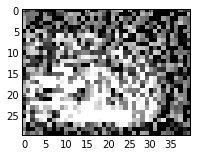

In [67]:
#WARNING!! If you run multiple scans (by pressing enter at the end of a scan) the sensor_readings0.npy file 
#  will incrememnt to sensor_readings1.npy, sensor_readings2.npy etc Make sure you read in the correct file. 

sr = np.load('data/sensor_readings0.npy')#[30*40:]
sr = [element - 900 for element in sr]

#TODO: Create the image vector from H and sr
#Hint: Because H is a special matrix, technically you do not need to perform any matrix operations
iv = np.dot(H, sr)


#Contrast code
m = median(iv)
s = std(iv)

if s< 20:
    s = 20

#Display the result
plt.figure(figsize=(3,4))
plt.imshow(np.reshape(iv,(30,40)), cmap='gray', vmin = m - s, vmax = m + s, interpolation='nearest')

<a id='task2a'></a>
##<span style="color:blue">Task 2a: Multipixel Scanning</span>
In the previous lab, each pixel was illuminated only once. This system is not very robust, because an error in any single measurement will be visible in the final image. Said another way, if we are taking a reading of the first pixel, and the projector flickers or we open the box, we lose all information about the first pixel and we cannot recover it.  

To address this, we will illuminate each pixel multiple times. This will effectively give us multiple chances to extract information from each pixel. To begin, we will focus on a 2x2 pixel section of the image. As we did last week, we will start by creating a small version and then scale this up to scan a full image (30x40 pixels). 

##Multipixel Scanning Matrix

Our goal is to illuminate certain pixels more than once. How can we illuminate every pixel in our 2x2 image more than once while  using only 4 imaging masks? The solution is to illuminate more than one pixel per mask. But how do you choose which pixels to illuminate in each mask?

Begin by assigning each grayscale value in the 2x2 section to a variable, $iv_{ij}$, where i is the row and j is the column. Your matrix corresponding to the 2x2 image will look like this:
$\begin{bmatrix} iv_{00} & iv_{01} \\ iv_{10} & iv_{11} \end{bmatrix}$.

Representing the sensor reading from the kth mask by $sr_k$, we write the following system of equations:

<br/>
<center>
**Lab3 System of Equations**

$$iv_{00} + iv_{01} + iv_{10} = sr_1$$
$$iv_{00} + iv_{11} = sr_2$$
$$iv_{01} + iv_{11} = sr_3$$
$$iv_{10} + iv_{11} = sr_4$$
<br/>

How would you represent these equations in terms of a matrix multiplication? Remember, your image vector and sensor vector are both 1D vectors, but your imaging mask should be a matrix. Also recall that we reshape columns of the masking matrix into the masks themselves. That is, the first column of the masking matrix will be reshaped into the first mask.  
<center>
**<span style="color:red">Create the matrix MH that represents the series of linear equations above.</span>**



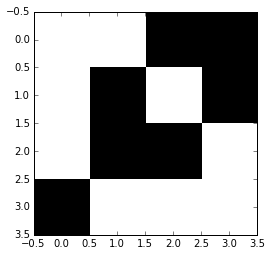

In [57]:
##TODO: Create imaging mask for the Lab3 system of equations, MH (dimensions should be 4x4)
MH = np.array([[1, 1, 0, 0],
               [1, 0, 1, 0],
               [1, 0, 0, 1],
               [0, 1, 1, 1]])


plt.imshow(MH, cmap='gray', interpolation='nearest')
plt.show()

**To help your understanding, this document will use an example system of equations to show the relationship between the system of linear equations, masking matrix MH, and the masks. The Example System of Equations is shown below:**
<br/>
<br/>
**<span style="color:red">*IMPORTANT* The `Lab3 System of Equations` and the `Example System of Equations` are not at all related. Use the Lab3 System of Equations for all parts of the lab. Use the Example System of Equations as a reference.</span>**
<br/>
<br/>
<center>
**Example System of Equations**
<center>

$$iv_{00} = sr_1$$
$$iv_{00} + iv_{01} = sr_2$$
$$iv_{00} + iv_{10} = sr_3$$
$$iv_{01} + iv_{10} + iv_{11} = sr_4$$
<br/>
**Imaging Mask for Example System of Equations**
<img src="http://www-inst.eecs.berkeley.edu/~ee16a/sp15/Labs/imaging/nb_img/sample_4x4.png" align="center" style="height:200px" />
</center>

As stated above, we will reshape columns of the masking matrix, MH, into the individual masks themselves. 
<br/>
<br/>
<center>
**<span style="color:red">Iterate through the 4 individual masks and display them.</span>**
<br/>
<br/>
Hint: Reference your code from last week where you checked to make sure the scanning matrix was producing the correct pattern by displaying each of the 25 individual masks. 
<br/>
<br/>
**Individual Masks for the Example System of Equations**
<br/>
<img src="http://www-inst.eecs.berkeley.edu/~ee16a/sp15/Labs/imaging/nb_img/sample_2x2_masks.png" align="center" style="height:200px" />
</center>

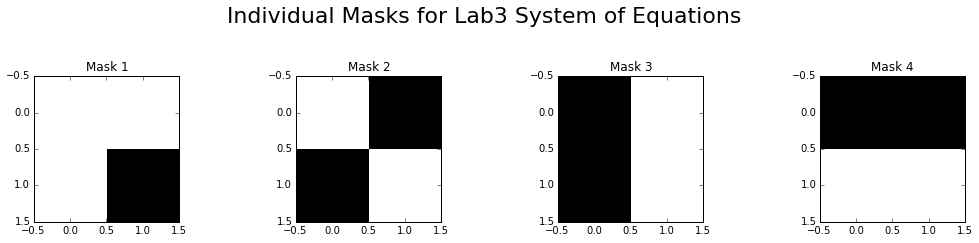

In [33]:
# Iterate through different masks

plt.figure(figsize=(18,12)).suptitle('Individual Masks for Lab3 System of Equations', fontsize=22)
for j in range(0,4):
    subplot(4,4,j+1)
    
    ##TODO: Reshape each column
    proj = MH.T[j].reshape((2,2))
  
    plt.imshow(proj,cmap='gray', interpolation='nearest');
    title('Mask ' + str(j+1))
plt.show()

<a id='task2b'></a>
##<span style="color:blue">Task 2b: Scaling up the Scanning Matrix</span>

We want to scan through our entire image in chunks of 2x2 pixels. To do this, we can extrapolate from our 4x4 MH matrix created above. 

**<span style="color:red">To scan a 6x8 image what dimensions must our scanning matrix have? What does the number of rows correspond to? What does the number of columns correspond to?</span>**

Design the **first 4 columns** of the scanning matrix for the 2x2 pixel area at the top left of the image.  Using the MH matrix for the Lab3 System of Equations, this means the 1st mask will illuminate 3 pixels, the 2nd mask will illuminate 2 pixels, the 3rd mask will illuminate 2 pixels, and the 4th mask will illuminate 2 pixels. 

**<span style="color:red">Design a 48x4 matrix that represents the first 4 columns of the imaging matrix. </span>** Name it ``Mtx_temp``.

*Draw out what Mtx_temp should look like and think about the goal in terms of matrix multiplication. There should be very few pixels in each column that are non-zero. Think about how you should index into Mtx_temp to change those values.*

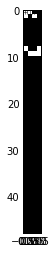

In [48]:
##TODO: Create Mtx_temp to create images of size M by N (in this case 6x8)
M = 6
N = 8

Mtx_temp = np.zeros(shape = (M * N, 4))
for j in range(0, 4):
    for i in range(0, 4):
        Mtx_temp[i % 2 + i // 2 * N][j] = MH[i][j]
        
plt.imshow(Mtx_temp, cmap='gray', interpolation='nearest')
plt.show()

**<span style="color:red">
Plot what the 4 different masks would look like (these should be 6x8 images). </span>** Does it make sense? Adjust ``Mtx_temp`` if needed.
<br/>
<center>
<br/>
**Example System of Equations**
<br/>
<img src="http://inst.eecs.berkeley.edu/~ee16a/images/imaging_img/Example_masks.JPG" align="center" style="height:200px" />
</center>

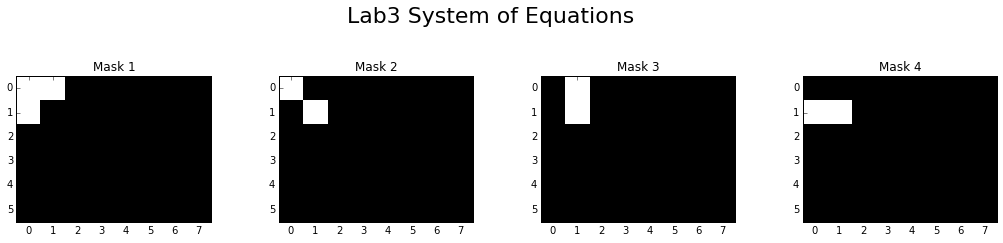

In [49]:
figure(figsize=(18,12)).suptitle('Lab3 System of Equations', fontsize=22)
for j in range(0,4):
    plt.subplot(4,4,j+1)
    
    ##TODO: Use each column of Mtx_temp to create a 6x8 image
    proj = np.reshape(Mtx_temp[:,j], (6,8)) 
    
    plt.imshow(proj,cmap='gray', interpolation='nearest');
    title('Mask ' + str(j+1))
plt.show()

**<span style="color:red">
Run the code below to shift and repeat the four columns of Mtx_temp across the entire matrix H. This will create the full 48x48 scanning matrix. </span>** 

The code will also plot which pixels will be illuminated with each mask, and you can check if your ``Mtx_temp`` was correct!


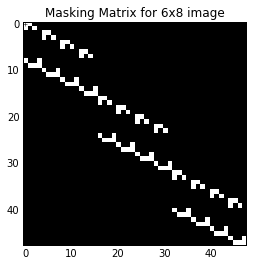

In [50]:
#Creates matrix H by extending the first 4 columns of the mask to a larger matrix

first = True
H=[]

for i in range(M//2):
    k = 2*i*N   
    for j in range(N//2):
        if first:
            H = Mtx_temp
            first = False
        else:
            H = np.hstack((H, np.roll(Mtx_temp, k+2*j, axis=0)))
            
plt.figure()
plt.title("Masking Matrix for 6x8 image")
plt.imshow(H, cmap='gray', interpolation='nearest')
plt.show()

**<span style="color:red">
What must be true about the above image to ensure that we scan every pixel at least once? </span>** 

<a id='task2c'></a>
##<span style="color:blue">Task 2c: Real Imaging</span>

Finally, we will use our matrix to image a real picture. Because our picture is fairly large, we want each individual mask to have dimensions 30x40 to match the 3:4 aspect ratio of the projector. 

**<span style="color:red">
Create a matrix H that could be used to scan a 30x40 image.</span>**

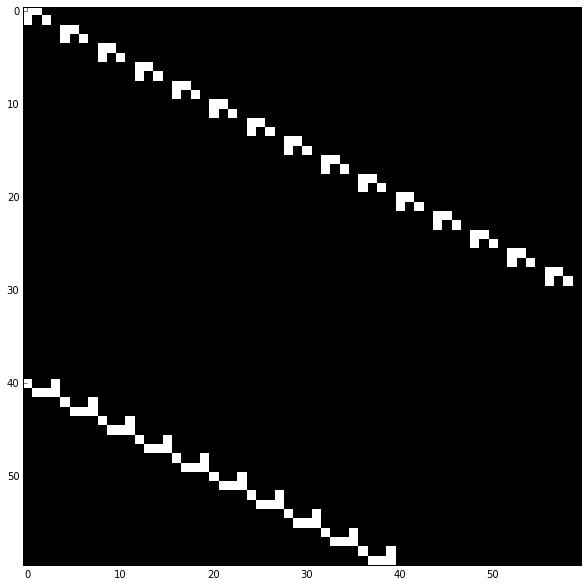

In [56]:
M = 30
N = 40

##TODO: Create Mtx_temp to create images of size M by N (in this case 30x40)

Mtx_temp = np.zeros(shape = (M * N, 4))
for j in range(0, 4):
    for i in range(0, 4):
        Mtx_temp[i % 2 + i // 2 * N][j] = MH[i][j]

#Creates the matrix H by extending the 4x4 mask to a larger matrix. Read through this code and try to understand it!
first = True
H=[]
for i in range(M//2):
    k=i*2*N
    for j in range(N//2):
        if first:
            H = Mtx_temp
            first = False
        else:
            H = np.hstack((H, np.roll(Mtx_temp, k+2*j, axis=0)))
       
    
#Change this variable to look at more or fewer rows and columns of H
num_rows_to_plot = 60

plt.figure(figsize=(10,10))
plt.imshow(H[0:num_rows_to_plot,0:num_rows_to_plot], cmap='gray', interpolation='nearest')
            
# Save the mask for use with the projector
np.save("imaging_mask.npy", H)
plt.show()

From the command line (in the current directory), run

`python capture_image.py`

The script projects patterns based on the masks you designed, `imaging_mask.npy`. The sensor readings will then be saved into an array named `sensor_readings.npy`.

**<span style="color:red">
Recreate the image vector from the sensor readings. Remember, you cannot just use the reshape command this time!
</span>**
<br/>
Hint: Think back to the representation of the imaging system as taking a matrix-vector product. How can we reconstruct the original image?

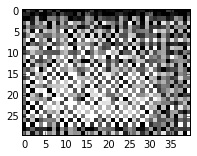

In [65]:
#WARNING!! If you run multiple scans (by pressing enter at the end of a scan) the sensor_readings0.npy file 
#  will incrememnt to sensor_readings1.npy, sensor_readings2.npy etc Make sure you read in the correct file. 
sr = np.load('data/sensor_readings0.npy')#[30*40:]

sr = [element - 900 for element in sr]

#TODO: Create the image vector from H and sr
inv = np.linalg.inv(H)
iv = np.dot(sr, inv)

#Contrast code
m = median(iv)
s = std(iv)

if s< 20:
    s = 20

#Display the result
plt.figure(figsize=(3,4))
plt.imshow(np.reshape(iv,(30,40)), cmap='gray', vmin = m - s, vmax = m + s, interpolation='nearest')

How does your image look? Is it the output you expected? If your image does not look as you expect it to, don't worry. Move on to the next task and come back to this part after.


<a id='task3'></a>
##<span style="color:blue">Task 3: Imaging Simulator</span>


Many of you have noticed that when the projector is displaying black, there is still a lot of light inside the box. This is a limitation of the projector, and it greatly affects our image quality. 

The following code runs an imaging simulator, simulate_capture.py. This script uses the `imaging_mask.npy` file (just as capture_image.py does), so make sure you've saved that file in the blocks of code above. The script (digitally) performs the same operations that occur inside the box, however we can control how much background light there is by changing the <span style="color:red">"Offset = 0"</span> line. Start by running the code with an offset of 0, and see what happens. The image that we will be "scanning" is this playing card:

<img src="http://inst.eecs.berkeley.edu/~ee16a/images/imaging_img/phantom.jpg" align="center" style="height:200px" />

Does the image resulting from the simulation look ok?

Now try increasing the offset to 1000. This is representative of what you might see in the lab when you take a scan. Does this image look familiar? Try to get rid of this effect by modifying sr before you reconstruct iv in the code below.

Try to use what you have learned from this simulator to make your physical card scans better (Task 2C). 


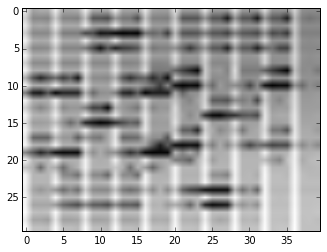

Raw sensor readings:
[ 1066.  1044.  1046. ...,  1052.  1052.  1052.]


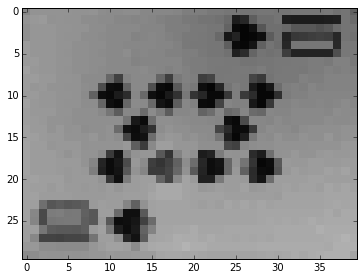

In [62]:
#Change this Offset variable to add a background signal to your image simulation

%run simulate_capture.py "Offset = 1000"

sr = np.load('sim_output.npy')
print("Raw sensor readings:")
print(sr)

#Modify sr here!
sr = [element - 1000 for element in sr]

#TODO: how do we recover iv from sr and H? 
#iv = 
iv = np.dot(sr,inv(H))


#Contrast code
m = mean(iv)
s = std(iv)

if s< 20:
    s = 20

#Display the result
plt.figure(figsize=(6,10))
plt.imshow(np.reshape(iv,(30,40)), cmap='gray', vmin = m - s, vmax = m + s, interpolation='nearest')
#plt.imshow(np.reshape(iv,(30,40)), cmap='gray', interpolation='nearest')

**<span style="color:red">Provide a brief overview of the differences between the single-pixel and multi-pixel scans. What are the possible causes for the differences? Which scanning modality should theoretically produce better images?</span>**

Congratulations on finishing the labs for the Imaging module!!!

<a id='task2d'></a>
##<span style="color:blue">(Optional) Task 4: Imaging Contest</span>

<a id='contest'></a>
##<span style="color:blue">(Optional) Contest</span>
This section is not required, but if you have additional time after completing the lab and are interested in making a better or more creative image now is your chance! The "Most Realistic" and "Most Creative" submissions from each lab section will be presented in lecture. You're welcome to submit just one, both, or neither. Submit files by emailing your lab GSI a .zip file. 

<a id='real'></a>
### <span style="color:blue">(Optional) Most Realistic Image</span>
Submit the image taken using the lab setup as well one from a phone camera for comparison.

**Brief description of submission (parameters/method used, etc)**
<br/>
Scan delay
<br/>
Solar cell angle (with stand, without, etc)-
<br/>
Averaging techniques used-

<a id='creative'></a>
### <span style="color:blue">(Optional) Most Creative Image</span>
This is very open ended and could include anything from imaging 3D objects to [alternative visualizations](http://matplotlib.org/gallery.html) (animations, colored plots, etc) of the raw data.

**Brief description of submission (interesting features, etc)**
<br/>